<a href="https://colab.research.google.com/github/AmritSDutta/colab_ml/blob/main/multitask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
from tqdm import tqdm

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import requests
import xarray as xr

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        reg_out, cls_out = model(X)
        loss1 = loss_reg(reg_out, y_reg)
        loss2 = loss_cls(cls_out, y_cls)
        loss = 0.5 * loss1 + 0.5 * loss2


        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.to(device)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            reg_out, cls_out = model(X)

            loss1 = loss_reg(reg_out, y_reg)
            loss2 = loss_cls(cls_out, y_cls)
            test_loss = 0.5 * loss1 + 0.5 * loss2
    test_loss /= num_batches
    print(f"Test: Avg loss: {test_loss:>8f} \n")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Dummy data
X = torch.randn(100, 10)
y_reg = torch.randn(100, 1)        # Regression target
y_cls = torch.randint(0, 2, (100, 1)).float()  # Classification target

# Model
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
        )
        self.reg_head = nn.Linear(64, 1)
        self.cls_head = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.shared(x)
        return self.reg_head(x), self.cls_head(x)

model = MultiTaskModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_reg = nn.MSELoss()
loss_cls = nn.BCELoss()

# Training loop
for epoch in range(100):
    reg_out, cls_out = model(X)
    loss1 = loss_reg(reg_out, y_reg)
    loss2 = loss_cls(cls_out, y_cls)
    loss = loss1 + loss2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 1.4678
Epoch 10: Loss = 1.3623
Epoch 20: Loss = 1.2898
Epoch 30: Loss = 1.2343
Epoch 40: Loss = 1.1891
Epoch 50: Loss = 1.1494
Epoch 60: Loss = 1.1129
Epoch 70: Loss = 1.0787
Epoch 80: Loss = 1.0459
Epoch 90: Loss = 1.0128


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - classification_loss: 0.8039 - loss: 2.1978 - regression_loss: 1.2957
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_loss: 0.7546 - loss: 2.1510 - regression_loss: 1.4801
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_loss: 0.8186 - loss: 1.9771 - regression_loss: 1.0919
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_loss: 0.7805 - loss: 1.7181 - regression_loss: 0.9038
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_loss: 0.8105 - loss: 1.6422 - regression_loss: 0.8571
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - classification_loss: 0.7503 - loss: 1.6568 - regression_loss: 0.8730
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - classification_loss: 0.7620 - loss: 1.4478 - regression_loss: 0.6836
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_loss: 0.7296 - loss: 1.3962 - regression_loss: 0.7399
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━

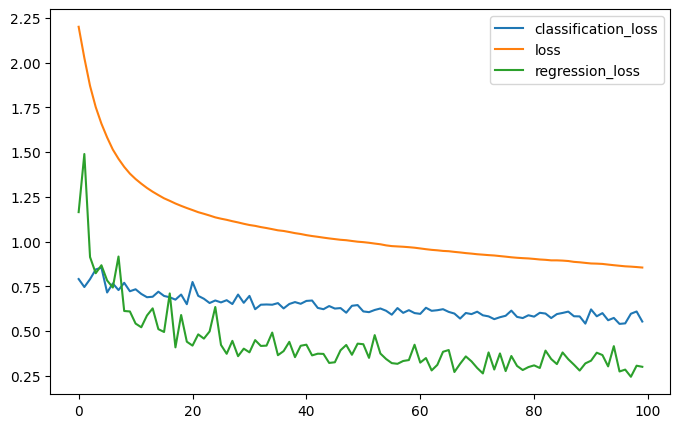

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers

# Dummy data
import numpy as np
X = X.numpy().astype(np.float32)
y_reg = y_reg.numpy().astype(np.float32)
y_cls = y_cls.numpy().astype(np.float32)

# Model
input_layer = layers.Input(shape=(10,))
shared = layers.Dense(64, activation='relu')(input_layer)

reg_out = layers.Dense(1, name='regression')(shared)
cls_out = layers.Dense(1, activation='sigmoid', name='classification')(shared)

model = models.Model(inputs=input_layer, outputs=[reg_out, cls_out])

model.compile(
    optimizer='adam',
    loss={
        'regression': 'mse',
        'classification': 'binary_crossentropy'
    },
    loss_weights={
        'regression': 1.0,
        'classification': 1.0
    }
)

history = model.fit(X, {'regression': y_reg, 'classification': y_cls}, epochs=100, verbose=1)

# Print final losses
losses = model.evaluate(X, {'regression': y_reg, 'classification': y_cls})
print("Final losses:", dict(zip(model.metrics_names, losses)))
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()